# Training with PyTorch 使用 PyTorch 进行训练

观看[yotube视频](https://www.youtube.com/watch?v=jF43_wj_DCQ)

## 介绍

在之前的视频中，我们讨论并演示了：

- 使用 `torch.nn` 模块中的神经网络层和函数来构建模型
- 自动梯度计算的机制，这是基于梯度的模型训练的核心
- 使用 TensorBoard 来可视化训练进展和其他活动

在本视频中，我们将为你的工具库添加一些新工具：

- 我们将熟悉数据集和数据加载器抽象，以及它们如何简化在训练循环中为模型提供数据的过程
- 我们将讨论特定的损失函数以及何时使用它们
- 我们将研究 PyTorch 优化器，它实现了根据损失函数的结果调整模型权重的算法

最后，我们将把所有这些组合在一起，展示完整的 PyTorch 训练循环的实际应用。

## 数据集与数据加载器

`Dataset` 和 `DataLoader` 类封装了从存储中提取数据并将其暴露给训练循环的过程。

- `Dataset` 负责访问和处理单个数据实例。
- `DataLoader` 从 `Dataset` 中提取数据实例（可以自动完成或通过定义的采样器），将它们收集成批，并返回供训练循环使用。`DataLoader` 可以处理所有类型的数据集，不论它们包含何种类型的数据。

在这个教程中，我们将使用 TorchVision 提供的 Fashion-MNIST 数据集。我们使用 `torchvision.transforms.Normalize()` 来对图像内容进行零中心化和标准化处理，并下载训练和验证数据集。

In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

data_path = os.path.expanduser("~/Data/Vision/FashionMNIST")

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST(data_path, train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST(data_path, train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


将数据可视化作为健全性检查：

Shirt  Shirt  Coat  Ankle Boot


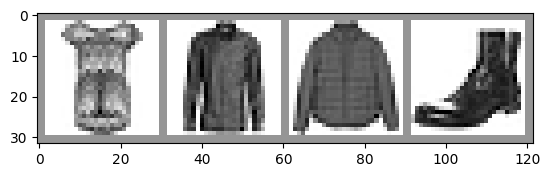

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

## 模型

在这个示例中我们使用的模型是 LeNet-5 的变体 —— 如果你已经观看了本系列之前的视频，它应该很熟悉。

In [3]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = GarmentClassifier()

### 损失函数

在这个示例中，我们将使用交叉熵损失。为了演示的目的，我们将创建一些虚拟输出和标签值，并将它们通过损失函数，然后检查结果。

In [4]:
loss_fn = torch.nn.CrossEntropyLoss()

# NB: Loss functions expect data in batches, so we're creating batches of 4
# Represents the model's confidence in each of the 10 classes for a given input
dummy_outputs = torch.rand(4, 10)
# Represents the correct class among the 10 being tested
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.4070, 0.0985, 0.3708, 0.7122, 0.1880, 0.6242, 0.7090, 0.5607, 0.5170,
         0.1250],
        [0.9666, 0.0143, 0.7458, 0.6594, 0.0675, 0.6823, 0.3238, 0.3263, 0.1322,
         0.0732],
        [0.1993, 0.0415, 0.6976, 0.4906, 0.1774, 0.2374, 0.1397, 0.9056, 0.7257,
         0.2410],
        [0.6188, 0.1370, 0.2332, 0.0567, 0.3781, 0.7456, 0.4332, 0.0430, 0.5304,
         0.5670]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.407946825027466


## 优化器

在这个示例中，我们将使用简单的 **带动量的随机梯度下降**。

可以尝试对该优化方案进行一些变化：

- 学习率决定了优化器每次更新权重的步长。不同的学习率对训练结果（准确率和收敛时间）有什么影响？
- 动量在多个步骤中将优化器向最强梯度的方向推进。改变该值会对结果产生什么影响？
- 尝试使用不同的优化算法，如平均SGD、Adagrad 或 Adam。它们的结果有什么不同？

In [5]:
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## 训练循环

下面是一个执行一个训练周期的函数。它从 `DataLoader` 中获取数据，并在每次循环时执行以下操作：

- 从 `DataLoader` 中获取一批训练数据
- 将优化器的梯度清零
- 执行推理操作 —— 即获取模型对输入批次的预测
- 计算这组预测结果与数据集标签之间的损失
- 根据学习权重计算反向梯度
- 告诉优化器执行一次学习步骤 —— 即根据观察到的梯度调整模型的学习权重
- 每1000批报告一次损失
- 最后，报告最后1000批的平均每批损失，用于与验证运行进行比较

In [6]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

## 每个 Epoch 的活动

每个 Epoch 完成后，我们需要执行以下几项操作：

- 通过检查未用于训练的数据集上的相对损失来执行验证，并报告结果
- 保存模型的副本

这里，我们将在 TensorBoard 中进行报告。为此，我们需要进入命令行启动 TensorBoard，并在另一个浏览器标签中打开它。

In [7]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

os.makedirs('models', exist_ok=True)

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'models/model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 1.901177402690053
  batch 2000 loss: 0.8780766501948237
  batch 3000 loss: 0.728695961739868
  batch 4000 loss: 0.6444999854215421
  batch 5000 loss: 0.6016919274502434
  batch 6000 loss: 0.5802384046618827
  batch 7000 loss: 0.572995180210215
  batch 8000 loss: 0.5105441415755777
  batch 9000 loss: 0.48245165446284227
  batch 10000 loss: 0.4790531073939055
  batch 11000 loss: 0.4673302624820499
  batch 12000 loss: 0.4474046237405273
  batch 13000 loss: 0.4428332263348857
  batch 14000 loss: 0.44363273066078546
  batch 15000 loss: 0.42238903905585173
LOSS train 0.42238903905585173 valid 0.5170979499816895
EPOCH 2:
  batch 1000 loss: 0.40829286965017675
  batch 2000 loss: 0.40010300725942943
  batch 3000 loss: 0.39529749495198485
  batch 4000 loss: 0.3769397274689982
  batch 5000 loss: 0.36115959496368305
  batch 6000 loss: 0.38121517101346397
  batch 7000 loss: 0.3749814493315062
  batch 8000 loss: 0.3579688208070802
  batch 9000 loss: 0.3699201780717121
  b

要加载模型的保存版本：

In [8]:
saved_model = GarmentClassifier()
saved_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

一旦你加载了模型，它就可以用于任何你需要的任务了——无论是继续训练、推理，还是进行分析。

需要注意的是，如果你的模型在构造函数中有影响模型结构的参数，那么你需要提供这些参数，并将模型配置为与保存时的状态完全相同。

## 其他资源

- PyTorch 官方文档中的 [数据工具](https://pytorch.org/docs/stable/data.html)，包括 Dataset 和 DataLoader
- 关于 [GPU 训练中使用固定内存](https://pytorch.org/docs/stable/notes/cuda.html#use-of-pinned-memory) 的说明
- 关于 [TorchVision](https://pytorch.org/vision/stable/datasets.html), [TorchText](https://pytorch.org/text/stable/datasets.html), 和 [TorchAudio](https://pytorch.org/audio/stable/index.html) 的数据集文档
- PyTorch 中可用的 [损失函数](https://pytorch.org/docs/stable/nn.html#loss-functions) 文档
- [torch.optim](https://pytorch.org/docs/stable/optim.html) 包的文档，其中包括优化器和相关工具，如学习率调度
- 详细的 [保存和加载模型的教程](https://pytorch.org/tutorials/beginner/saving_loading_models.html)
- PyTorch 教程部分提供了关于分类、生成对抗网络、强化学习等领域的大量训练任务的 [教程](https://pytorch.org/tutorials/)